# **Install Dependencies**

In [1]:
!pip install spacy textblob networkx matplotlib pyvis
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **Import Libraries**

In [2]:
import spacy
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network


## **Input Text (Synthetic Example)**

In [3]:
text = """
Elon Musk, a bold and risk-taking entrepreneur, founded SpaceX and leads Tesla.
Under his leadership, SpaceX aims to colonize Mars.
Meanwhile, Jeff Bezos, a methodical and ambitious thinker, founded Blue Origin to explore space too.
"""


# **Named Entity Extraction (NER)**

In [4]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

entities = [(ent.text, ent.label_) for ent in doc.ents]
entities


[('Elon Musk', 'PERSON'),
 ('Tesla', 'PERSON'),
 ('SpaceX', 'PERSON'),
 ('Mars', 'LOC'),
 ('Jeff Bezos', 'PERSON'),
 ('Blue Origin', 'ORG')]

# **Personality Trait Extraction (Simple Sentiment + Adjective Rules)**

In [5]:
import re

def extract_personality(text, name):
    # Find sentences mentioning the person
    sentences = [sent.text for sent in nlp(text).sents if name in sent.text]
    traits = []
    for sent in sentences:
        # Simple adjective extraction
        adjectives = [token.text for token in nlp(sent) if token.pos_ == "ADJ"]
        if adjectives:
            traits.extend(adjectives)
        # Sentiment using TextBlob
        polarity = TextBlob(sent).sentiment.polarity
        if polarity > 0.2:
            traits.append("positive")
        elif polarity < -0.2:
            traits.append("negative")
    return list(set(traits))

people = [ent[0] for ent in entities if ent[1] == "PERSON"]

personality_map = {p: extract_personality(text, p) for p in people}
personality_map


{'Elon Musk': ['bold', 'positive'],
 'Tesla': ['bold', 'positive'],
 'SpaceX': ['bold', 'positive'],
 'Jeff Bezos': ['ambitious', 'methodical']}

# **Build the Knowledge Graph**

In [6]:
G = nx.Graph()

# Add nodes for all entities
for ent, label in entities:
    G.add_node(ent, label=label)

# Add personality as node attributes
for person, traits in personality_map.items():
    G.nodes[person]['personality'] = ", ".join(traits)

# Create edges based on co-occurrence in same sentence
for sent in doc.sents:
    sent_ents = [ent.text for ent in sent.ents]
    for i in range(len(sent_ents)):
        for j in range(i+1, len(sent_ents)):
            G.add_edge(sent_ents[i], sent_ents[j], relation="co_occurrence")

print("Nodes:", G.nodes(data=True))
print("Edges:", G.edges(data=True))


Nodes: [('Elon Musk', {'label': 'PERSON', 'personality': 'bold, positive'}), ('Tesla', {'label': 'PERSON', 'personality': 'bold, positive'}), ('SpaceX', {'label': 'PERSON', 'personality': 'bold, positive'}), ('Mars', {'label': 'LOC'}), ('Jeff Bezos', {'label': 'PERSON', 'personality': 'ambitious, methodical'}), ('Blue Origin', {'label': 'ORG'})]
Edges: [('Elon Musk', 'Tesla', {'relation': 'co_occurrence'}), ('SpaceX', 'Mars', {'relation': 'co_occurrence'}), ('Jeff Bezos', 'Blue Origin', {'relation': 'co_occurrence'})]


# **Visualize the Graph (PyVis Interactive)**

In [11]:
from pyvis.network import Network
from IPython.display import display, HTML

# Create the network
net = Network(height="600px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# Color map by entity type
color_map = {
    "PERSON": "#6fa8dc",
    "ORG": "#f6b26b",
    "LOC": "#93c47d"
}

# Add nodes with colors and labels
for node, data in G.nodes(data=True):
    ent_type = data.get('label', 'UNKNOWN')
    color = color_map.get(ent_type, "#c9daf8")
    title = f"Type: {ent_type}<br>Personality: {data.get('personality', 'N/A')}"
    net.add_node(node, label=node, color=color, title=title)

# Add edges
for src, dst, data in G.edges(data=True):
    net.add_edge(src, dst, title=data.get('relation', 'related_to'))

# Display graph
net.show("kg_personality.html")
display(HTML("kg_personality.html"))


kg_personality.html


# **Matplotlib Static View**

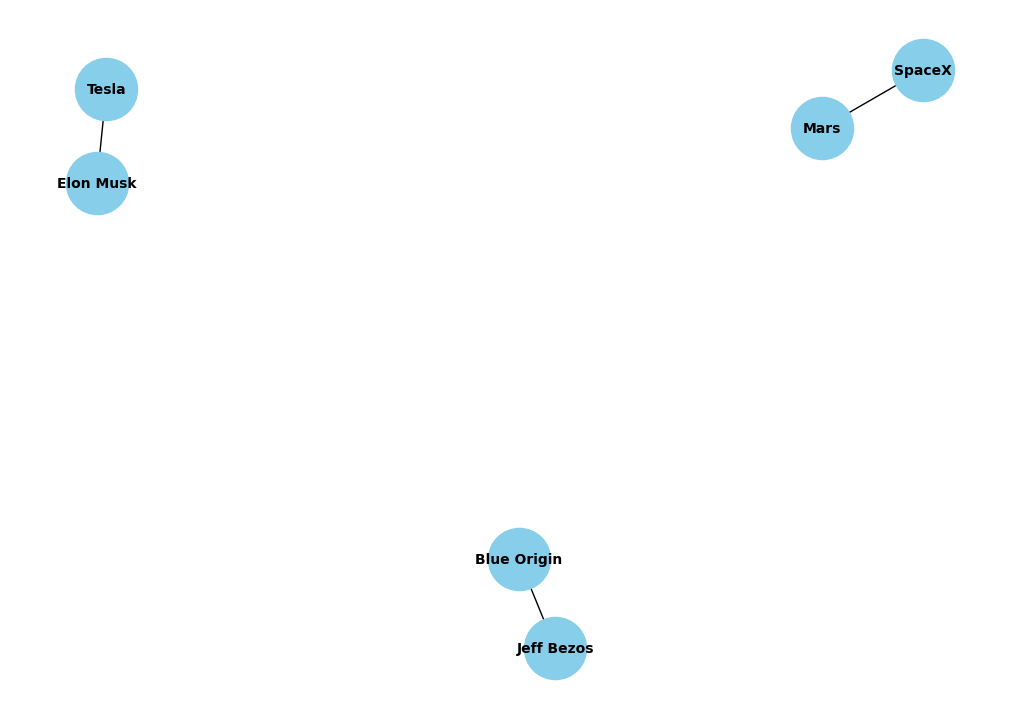

In [13]:
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=10, font_weight="bold")
plt.show()
